Python: 3.7.4 (tags/v3.7.4:e09359112e, Jul  8 2019, 20:34:20) [MSC v.1916 64 bit (AMD64)]

|모듈|버젼|
|----|----|
|pandas|0.25.1|
|numpy|1.18.5|
|sklearn|0.21.3|
|scipy|1.5.2|
|mlxtend|0.15.0.0|
|statsmodels|0.11.1|
|imblearn|0.5.0|
|xgboost|0.80|

In [1]:
import pandas as pd
import numpy as np
import sklearn
import scipy 
import mlxtend
import statsmodels
import imblearn
import xgboost as xgb
import sys

print(sys.version)
for i in [pd, np, sklearn, scipy, mlxtend, statsmodels, imblearn, xgb]:
    print(i.__name__,  i.__version__)

3.7.4 (tags/v3.7.4:e09359112e, Jul  8 2019, 20:34:20) [MSC v.1916 64 bit (AMD64)]
pandas 0.25.1
numpy 1.18.5
sklearn 0.21.3
scipy 1.5.2
mlxtend 0.15.0.0
statsmodels 0.11.1
imblearn 0.5.0
xgboost 0.80


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

## 문제 8번, Kaggle 형 20점

이전 문제들에서 ‘에너지 생산량에 log를 취한 값(generate_log)’을 예측하는 모델을 만들어 보았다. 

본 문제에서는 ‘generate_log’를 예측하는 최고의 성능을 내는 회귀 모델을 자유롭게 구현하도록 한다. 

알고리즘, 파라미터, 변수 선정 등 다양한 시도를 통해 더 높은 정확도를 보이는 모델을 개발하시오.

- ‘prof2103_2_data.csv’의 1월부터 8월까지 데이터를 train set으로 활용한다.
   (이외 주어진 모든 데이터셋 활용 가능)

- ‘prof2103_2_data.csv’의 9월부터 12월까지 데이터를 test set으로 사용한다.

(이 데이터들의 에너지 생산량(generate) 컬럼은 모두 결측치이다.)

- 가장 높은 성능을 가지는 예측모델을 개발하는 것이 목표이며, 성능 평가 기준은 RMSE(root mean square error, 아래 식 참고)이다.


$RMSE=\sqrt{\frac{1}{N}\sum_{t=1}^n(\hat{y_i} - y_i)^2}$     ($\hat{y}$  : 예측값, $y$: 실제값)

**제출 ① - 예측값  (answer6.csv)**

-	‘prof2103_2_data.csv’의 9~12월 데이터(101,525행)에 대한 ‘generate_log’ 예측값

-	다음 양식에 따라 제출

|datetime|user_id|generate_log|
|--------|-------|------------|
|2019-09-01 00:00:00|568|1.23|
|2019-09-01 00:00:00|689|4.56|
|2019-09-01 00:00:00|482|7.89|
|…|…|…|
|2019-12-31 23:00:00|1122|1.35|

-	구분자(Seperator)를 Comma(,)로 하는 txt 확장자 파일을 생성하여 업로드

**제출 ② – answer6 소스 코드**

(브라이틱스: answer8_이름.json, 파이썬: answer8_이름.py / answer8_이름.ipynb)

- 캐글형 문제에 대한 소스 코드를 따로 작성
- 모델 내, 데이터셋 로드부터 예측결과 조회까지 정상수행여부 확인 후 업로드

**제출** 위의 ①, ②에 해당하는 파일들(예측 결과, 풀이 모델)을 answer8_이름.zip 으로 압축하여 시스템에 첨부하시오. 

(2개 파일 중, 하나라도 누락 시 0점 처리)


In [3]:
# 풀이에 필요한 데이터셋을 불러 옵니다.

df_weather = pd.read_csv('data/prof2103_2_weather.csv', parse_dates=['datetime'])
df_meta = pd.read_csv('data/prof2103_2_building_metadata.csv')
df_data = pd.read_csv('data/prof2103_2_data.csv', parse_dates=['datetime'])

In [4]:
# 전처리에서 Interpolation을 들고 옵니다.
df_weather.sort_values(['datetime'], inplace=True)
X_itp = ['temperature', 'cloud', 'dew_point', 'rain_hourly', 'air_pressure', 'wind_direction']

def interpolate(df):
    df_ = df[X_itp].copy()
    for i, col in enumerate(X_itp):
        if df_[col].notna().sum() > 0:
            df_.iloc[[0, -1], i] = df_.loc[df_[col].notna(), col].iloc[[0, -1]].values
    return df_.interpolate()

df_weather[X_itp] = df_weather.groupby('region_id')[X_itp].apply(
    lambda x: pd.DataFrame(interpolate(x), index=x.index, columns=x.columns)
)

# 구간화를 통한 보정 로직을 들고 옵니다.
df_weather['cloud'] = pd.cut(
    df_weather['cloud'], 
    bins=[0, 2, 4, 6, 8, np.inf], 
    right=False, 
    labels=[0, 2, 4, 6, 8]
).astype(float)

# weather의 시간 조정을 합니다, data 데이터프레임과 결합을 위한
s_temp_mean = df_weather.assign(
    hour = lambda x: x['datetime'].dt.hour
).groupby(['region_id', 'hour'])['temperature'].mean()
df_temp_mean = s_temp_mean.reset_index()

s_shift_time = df_temp_mean.groupby('region_id')\
                    .apply(
                        lambda x: pd.Timedelta(hours=14 - x.set_index('hour')['temperature'].idxmax())
                    )

# datetime은 시스템 예약어라 dictionary unpacking을 통해서도 넣어봅니다.
df_weather_s = df_weather.assign(
    **{'datetime': lambda x: x['datetime'] + x['region_id'].map(s_shift_time)}
)

df_data_meta = df_data.merge(
    df_meta, on='user_id'
)

df_data_weather = df_data_meta.merge(df_weather_s, on=['datetime', 'region_id'], how='left')

In [5]:
# 일자형 파생변수를 만들어 봅니다.
df_data_weather['month'] = df_data_weather['datetime'].dt.month
df_data_weather['hour'] = df_data_weather['datetime'].dt.hour
df_data_weather['day'] = df_data_weather['datetime'].dt.day

# log 파생변수를 만듭니다.
df_data_weather['area_log'] = np.log(df_data_weather['area'] + 1)
df_data_weather['num_floors_log'] = np.log(df_data_weather['num_floors'] + 1)

# 타깃 변수를 만듭니다.
df_data_weather['generate_log'] = np.log(df_data_weather['generate'] + 1)

In [6]:
df_train = df_data_weather.loc[df_data_weather['datetime'] < "2019-09-01"].copy()
df_test = df_data_weather.loc[df_data_weather['datetime'] >= "2019-09-01"].copy()
df_test[['temperature', 'dew_point', 'wind_direction']] = \
        df_test.groupby('region_id')[['temperature', 'dew_point', 'wind_direction']].fillna(method='ffill')

In [7]:
# Decision Tree 계열의 모델을 사용하려 합니다. 나머지 결측치는 일반 수치와 구분이 되도록 -1000으로 합니다.
df_train2 = df_train.fillna(-1000)
df_test2 = df_test.fillna(-1000)

In [8]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

# test가 시점을 기준으로 나누어졌으니 
# 검증셋도 동일하게 시점을 기준으로 나눕니다.
df_val_train = df_train2.loc[df_train2['datetime'] < '2019-07-01']
df_val_test = df_train2.loc[df_train2['datetime'] >= '2019-07-01']

# 검증 함수입니다.
def evaluate(reg, X):
    reg.fit(df_val_train[X], df_val_train['generate_log'])
    rmse_train = mean_squared_error(df_val_train['generate_log'], reg.predict(df_val_train[X]))
    rmse_test = mean_squared_error(df_val_test['generate_log'], reg.predict(df_val_test[X]))
    return rmse_train, rmse_test

# 제출 함수입니다.
def answer(reg, X):
    reg.fit(df_train2[X], df_train2['generate_log'])
    df_ans = pd.DataFrame(
        {
            'datetime': df_test['datetime'],
            'user_id': df_test['user_id'],
            'generate_log': reg.predict(df_test2[X])
        }
    )
    df_ans.to_csv('answer8.csv', index=None)
    return df_ans

# 범주형 입력 변수입니다.
X_cat = ['region_id', 'usage']
# 수치형 입력 변수입니다.
X_num = [i for i in df_train2.columns if i not in X_cat and i not in ['datetime', 'user_id', 'generate', 'generate_log']]

df_solution = pd.read_csv('data/prof2103_2_data_solution.csv')
df_solution.sort_values(['datetime', 'user_id'], inplace=True)

In [14]:
# Baseline 모델입니다.
from sklearn.tree import DecisionTreeRegressor

X_num_dt = [i for i in X_num if i not in ['area_log', 'num_floors_log', 'month', 'day']]
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(categories='auto'), X_cat),
    ('pt', 'passthrough', X_num_dt)
])

X_dt = X_cat + X_num_dt
reg_dt = make_pipeline(
    ct,
    DecisionTreeRegressor(random_state=123)
)
evaluate(reg_dt, X_dt)

(2.8190999069753975e-05, 0.9130405353320994)

In [15]:
df_ans_dt = answer(reg_dt, X_dt)

In [16]:
mean_squared_error( 
    np.log(df_solution['generate'] + 1),
    df_ans_dt.sort_values(['datetime', 'user_id'])['generate_log']
)

2.1032404589510167

In [26]:
# 개선 모델입니다.
from sklearn.tree import DecisionTreeRegressor

X_num_dt = [i for i in X_num if i not in ['area_log', 'num_floors_log', 'day']]
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(categories='auto'), X_cat),
    ('pt', 'passthrough', X_num_dt)
])

X_dt = X_cat + X_num_dt
reg_dt = make_pipeline(
    ct,
    DecisionTreeRegressor(max_depth=20, min_samples_leaf=16, random_state=123)
)
evaluate(reg_dt, X_dt)

(0.2620673951485717, 0.572420788409494)

In [27]:
df_ans_dt = answer(reg_dt, X_dt)

In [28]:
mean_squared_error( 
    np.log(df_solution['generate'] + 1),
    df_ans_dt.sort_values(['datetime', 'user_id'])['generate_log']
)

0.5882427526421101

In [30]:
# 개선 모델입니다.
from sklearn.ensemble import RandomForestRegressor

X_num_rf = [i for i in X_num if i not in ['area_log', 'num_floors_log', 'day']]
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(categories='auto'), X_cat),
    ('pt', 'passthrough', X_num_rf)
])

X_rf = X_cat + X_num_rf
reg_rf = make_pipeline(
    ct,
    RandomForestRegressor(n_estimators=50, max_depth=19, min_samples_leaf=8, random_state=123)
)
evaluate(reg_rf, X_rf)

(0.21713715268073897, 0.5143521792942983)

In [31]:
df_ans_rf = answer(reg_rf, X_rf)

In [32]:
mean_squared_error( 
    np.log(df_solution['generate'] + 1),
    df_ans_rf.sort_values(['datetime', 'user_id'])['generate_log']
)

0.5453251167898973

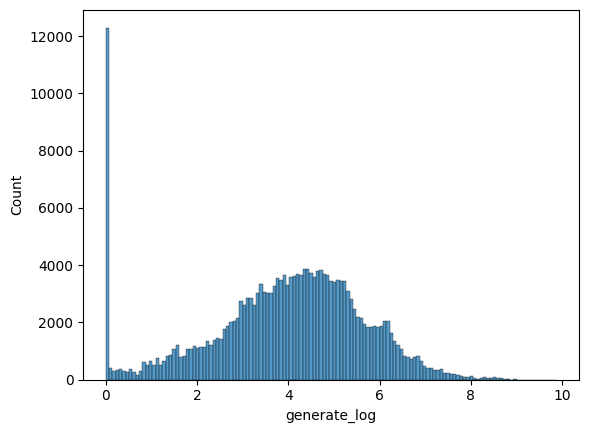

In [35]:
sns.histplot(df_train['generate_log'])
plt.show()

In [36]:
df_train['doy'] = df_train['datetime'].dt.dayofyear

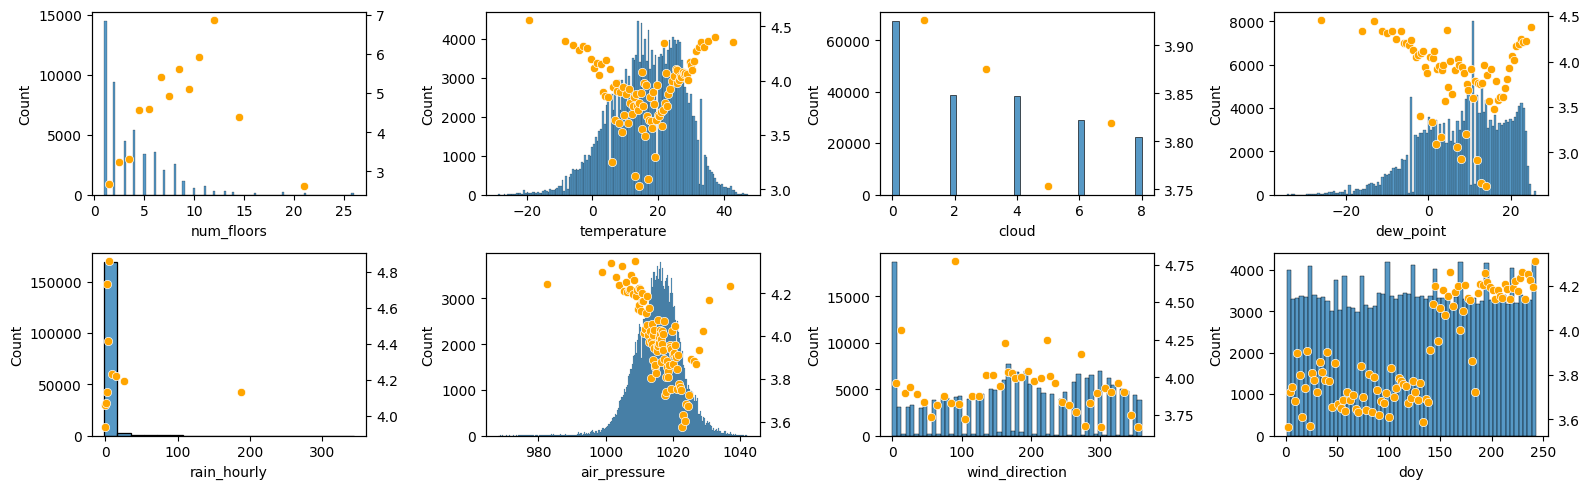

In [37]:
fig, axes = plt.subplots(2, 4, figsize=(16, 5))
for i, ax in zip(
        ['num_floors', 'temperature', 'cloud', 'dew_point', 'rain_hourly', 'air_pressure', 'wind_direction', 'doy'],
        axes.ravel()
    ):    
    sns.histplot(data=df_train, x=i, ax=ax)
    s_qmean = df_train.groupby(pd.qcut(df_train[i], q=100, duplicates='drop'))['generate_log'].mean()
    sns.scatterplot(
        x=s_qmean.index.map(lambda x: (x.left + x.right) / 2),
        y=s_qmean.values,
        ax=ax.twinx(), color='orange'
    )
plt.tight_layout()
plt.show()